<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import uuid
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def detect_duplicates(folder):
    seen = {}
    duplicates = {}
    for cls in os.listdir(folder):
        class_path = os.path.join(folder, cls)
        if not os.path.isdir(class_path):
            continue
        duplicates[cls] = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_hash = hash(img.tobytes())
                if img_hash in seen:
                    duplicates[cls].append(img_path)
                else:
                    seen[img_hash] = img_path
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return duplicates


def augment_image(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def augment_duplicates(folder, duplicates_per_class, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cls, duplicate_files in duplicates_per_class.items():
        class_output_path = os.path.join(output_folder, cls)
        os.makedirs(class_output_path, exist_ok=True)
        for filepath in duplicate_files:
            try:
                with Image.open(filepath) as img:
                    augmented_img = augment_image(img)
                    new_filename = f"{os.path.splitext(os.path.basename(filepath))[0]}_{uuid.uuid4().hex[:6]}.png"
                    new_filepath = os.path.join(class_output_path, new_filename)
                    augmented_img.save(new_filepath)
            except Exception as e:
                print(f"Error augmenting {filepath}: {e}")
                
def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.2):
    test_ratio = 1 - (train_ratio + val_ratio)
    for cls in os.listdir(source_dir):
        class_path = os.path.join(source_dir, cls)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        train, temp = train_test_split(images, test_size=(1 - train_ratio), stratify=[cls]*len(images), random_state=42)
        val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=[cls]*len(temp), random_state=42)
        for subset, subset_images in zip(["train", "val", "test"], [train, val, test]):
            subset_path = os.path.join(output_dir, subset, cls)
            os.makedirs(subset_path, exist_ok=True)
            for img_name in subset_images:
                shutil.copy(os.path.join(class_path, img_name), os.path.join(subset_path, img_name))

# Define Paths
dataset_path = "D:/Datasets_Retina"
augmented_dataset_path = "D:/Datasets_Retina_Augmented"
combined_dataset_path = "D:/Datasets_Combined"
final_dataset_path = "D:/Datasets_Final"

# Handle duplicates
duplicates_per_class = detect_duplicates(dataset_path)
augment_duplicates(dataset_path, duplicates_per_class, augmented_dataset_path)

# Combine original and augmented datasets
shutil.copytree(dataset_path, combined_dataset_path, dirs_exist_ok=True)
shutil.copytree(augmented_dataset_path, combined_dataset_path, dirs_exist_ok=True)

# Split dataset properly to prevent data leakage
split_data(combined_dataset_path, final_dataset_path)

# Image Processing Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for training set
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3]
)

# Load Data
train_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "train"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
val_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "val"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)
test_generator = data_gen.flow_from_directory(os.path.join(final_dataset_path, "test"), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

# Improved CNN Model with Regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# Compile Model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train Model
model.fit(train_generator, validation_data=val_generator, epochs=25, callbacks=[early_stopping])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Fundus", "Fundus"]))


Found 5222 images belonging to 2 classes.
Found 1492 images belonging to 2 classes.
Found 748 images belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9392 - loss: 1.7771 - val_accuracy: 0.5442 - val_loss: 19.9984
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9706 - loss: 0.9057 - val_accuracy: 0.5509 - val_loss: 18.9203
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9772 - loss: 0.7324 - val_accuracy: 0.7882 - val_loss: 5.6246
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9808 - loss: 0.6411 - val_accuracy: 0.9155 - val_loss: 2.9250
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9848 - loss: 0.5825 - val_accuracy: 0.9350 - val_loss: 2.2543
Epoch 6/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9776 - loss: 0.6140 - val_accuracy: 0.9015 - val_loss: 3.1671
Epoch 7/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9800 - loss: 0.6211 - val_accuracy: 0.9403 - val_loss: 1.7575
Epoch 8/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9742 - loss: 0.6756 - val_ac

In [ ]:
import os
import shutil
import uuid
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


def detect_duplicates(folder):
    
    seen = {}
    duplicates = {}
    for cls in os.listdir(folder):
        class_path = os.path.join(folder, cls)
        if not os.path.isdir(class_path):
            continue
        duplicates[cls] = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_hash = hash(img.tobytes())
                if img_hash in seen:
                    duplicates[cls].append(img_path)
                else:
                    seen[img_hash] = img_path
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return duplicates

def augment_image(image):
    return image.transpose(Image.FLIP_LEFT_RIGHT)

def augment_duplicates(folder, duplicates_per_class, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cls, duplicate_files in duplicates_per_class.items():
        class_output_path = os.path.join(output_folder, cls)
        os.makedirs(class_output_path, exist_ok=True)
        for filepath in duplicate_files:
            try:
                with Image.open(filepath) as img:
                    augmented_img = augment_image(img)
                    new_filename = f"{os.path.splitext(os.path.basename(filepath))[0]}_{uuid.uuid4().hex[:6]}.png"
                    new_filepath = os.path.join(class_output_path, new_filename)
                    augmented_img.save(new_filepath)
            except Exception as e:
                print(f"Error augmenting {filepath}: {e}")



Training Fold 1/5...

Found 4177 validated image filenames belonging to 2 classes.
Found 1045 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 591s 5s/step - accuracy: 0.9324 - loss: 1.6254 - val_accuracy: 0.5445 - val_loss: 26.7452
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - accuracy: 0.9676 - loss: 0.9263 - val_accuracy: 0.5445 - val_loss: 22.1755
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9780 - loss: 0.7868 - val_accuracy: 0.5914 - val_loss: 12.8744
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9775 - loss: 0.7407 - val_accuracy: 0.7713 - val_loss: 6.6773
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9776 - loss: 0.6766 - val_accuracy: 0.8325 - val_loss: 3.8048
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 651s 5s/step - accuracy: 0.9770 - loss: 0.6196 - val_accuracy: 0.9139 - val_loss: 1.9598
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9839 - loss: 0.5685 - val_accuracy: 0.9244 - val_loss: 1.7238
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9779 - loss: 0.5708 - val_a

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9090 - loss: 2.6395 - val_accuracy: 0.6919 - val_loss: 2.4172
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9679 - loss: 0.8916 - val_accuracy: 0.7426 - val_loss: 3.5553
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9725 - loss: 0.7150 - val_accuracy: 0.7656 - val_loss: 5.1017
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 938s 7s/step - accuracy: 0.9726 - loss: 0.6940 - val_accuracy: 0.8402 - val_loss: 4.2115
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9760 - loss: 0.6415 - val_accuracy: 0.8469 - val_loss: 3.5209
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.9811 - loss: 0.6133 - val_accuracy: 0.8880 - val_loss: 2.4216
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9764 - loss: 0.5698 - val_accuracy: 0.9081 - val_loss: 1.9503
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9763 - loss: 0.5543 - val_accu

Next time remeber to print training , testing and validation accuracies, when fitting use history = model.fit....
Reduce Model Complexity: Try reducing the number of filters or layers.
Early Stopping: Reduce patience to stop training before overfitting occurs.
and trainig and tesing curves

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Paths
dataset_path = "D:/Datasets_Retina"
final_dataset_path = "D:/Datasets_Final"
model_save_path = "D:/saved_model_fundus.h5"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
K_FOLDS = 3  

# Function for Image Preprocessing
def preprocess_image(img_path):
    try:
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        img = img.resize(IMG_SIZE)  # Resize to target size
        img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Load Data
all_images = []
all_labels = []

for cls in os.listdir(os.path.join(final_dataset_path, "train")):
    class_path = os.path.join(final_dataset_path, "train", cls)
    label = 1 if cls == "Fundus" else 0  # Binary classification
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            all_images.append(img_path)
            all_labels.append(label)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
    print(f"\nTraining Fold {fold + 1}/{K_FOLDS}...\n")

    train_images, val_images = all_images[train_idx], all_images[val_idx]
    train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]

    train_df = pd.DataFrame({"filename": train_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in train_labels]})
    val_df = pd.DataFrame({"filename": val_images, "class": [ "Fundus" if lbl == 1 else "Non-Fundus" for lbl in val_labels]})


    # Data Augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.3,
        shear_range=0.2,
        brightness_range=[0.7, 1.3]
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col="filename", y_col="class",
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="binary", shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col="filename", y_col="class",
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="binary", shuffle=False
    )

    # Optimized CNN Model
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks for Early Stopping and Best Model Saving
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max')

    # Train Model
    model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping, checkpoint])

    # Evaluate Model
    val_loss, val_accuracy = model.evaluate(val_generator)
    fold_accuracies.append(val_accuracy * 100)
    print(f"Fold {fold+1} Validation Accuracy: {val_accuracy * 100:.2f}%")

# Compute Final Cross-Validation Accuracy
final_accuracy = np.mean(fold_accuracies)
print(f"\nFinal Cross-Validated Accuracy: {final_accuracy:.2f}%")
best_model = tf.keras.models.load_model(model_save_path)

# Test Data Evaluation
test_generator = val_datagen.flow_from_directory(
    os.path.join(final_dataset_path, "test"),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=False
)

y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Fundus", "Fundus"]))

best_model.save(model_save_path)
print(f"\nModel saved at: {model_save_path}")



Training Fold 1/3...

Found 3481 validated image filenames belonging to 2 classes.
Found 1741 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9208 - loss: 3.0141

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9211 - loss: 3.0100 - val_accuracy: 0.5445 - val_loss: 50.2085
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.9532 - loss: 2.2498 - val_accuracy: 0.5445 - val_loss: 44.5896
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9686 - loss: 1.9827

109/109 ━━━━━━━━━━━━━━━━━━━━ 420s 4s/step - accuracy: 0.9686 - loss: 1.9817 - val_accuracy: 0.5589 - val_loss: 23.8171
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9703 - loss: 1.8500

109/109 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9703 - loss: 1.8491 - val_accuracy: 0.6479 - val_loss: 22.9004
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9642 - loss: 1.8123

109/109 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9643 - loss: 1.8109 - val_accuracy: 0.8909 - val_loss: 4.0235
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9808 - loss: 1.4421

109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9808 - loss: 1.4418 - val_accuracy: 0.9150 - val_loss: 5.2394
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9825 - loss: 1.3709

109/109 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step - accuracy: 0.9825 - loss: 1.3706 - val_accuracy: 0.9696 - val_loss: 2.0538
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - accuracy: 0.9806 - loss: 1.2586 - val_accuracy: 0.9563 - val_loss: 2.3374
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9757 - loss: 1.1993

109/109 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - accuracy: 0.9757 - loss: 1.1996 - val_accuracy: 0.9793 - val_loss: 1.6569
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 498s 5s/step - accuracy: 0.9787 - loss: 1.1861 - val_accuracy: 0.9742 - val_loss: 1.6485
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 563s 5s/step - accuracy: 0.9787 - loss: 1.1588 - val_accuracy: 0.9736 - val_loss: 1.4696
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.9858 - loss: 1.0853 - val_accuracy: 0.9638 - val_loss: 1.5836
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9782 - loss: 1.0154 - val_accuracy: 0.9742 - val_loss: 1.4151
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.9807 - loss: 0.9992 - val_accuracy: 0.9500 - val_loss: 2.0057
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9816 - loss: 0.9783

109/109 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.9816 - loss: 0.9781 - val_accuracy: 0.9805 - val_loss: 1.2149
Epoch 16/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9833 - loss: 0.8815 - val_accuracy: 0.9765 - val_loss: 1.2491
Epoch 17/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9790 - loss: 0.8762 - val_accuracy: 0.9799 - val_loss: 1.0367
Epoch 18/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9803 - loss: 0.8632 - val_accuracy: 0.9615 - val_loss: 1.3185
Epoch 19/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.9792 - loss: 0.8680 - val_accuracy: 0.6623 - val_loss: 4.4782
Epoch 20/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9675 - loss: 1.2353

109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9675 - loss: 1.2358 - val_accuracy: 0.9851 - val_loss: 1.6433
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9924 - loss: 0.8970
Fold 1 Validation Accuracy: 97.99%

Training Fold 2/3...

Found 3481 validated image filenames belonging to 2 classes.
Found 1741 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9245 - loss: 3.0907

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9247 - loss: 3.0863 - val_accuracy: 0.5439 - val_loss: 31.0364
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 814s 7s/step - accuracy: 0.9682 - loss: 1.8253 - val_accuracy: 0.5439 - val_loss: 39.0930
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9747 - loss: 1.6873

109/109 ━━━━━━━━━━━━━━━━━━━━ 788s 7s/step - accuracy: 0.9746 - loss: 1.6879 - val_accuracy: 0.5485 - val_loss: 37.0861
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9708 - loss: 1.7950

109/109 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - accuracy: 0.9708 - loss: 1.7948 - val_accuracy: 0.6904 - val_loss: 14.7714
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9766 - loss: 1.7369

109/109 ━━━━━━━━━━━━━━━━━━━━ 781s 7s/step - accuracy: 0.9766 - loss: 1.7362 - val_accuracy: 0.8334 - val_loss: 10.6510
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9738 - loss: 1.7707

109/109 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.9738 - loss: 1.7699 - val_accuracy: 0.9495 - val_loss: 2.9009
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.9749 - loss: 1.5567 - val_accuracy: 0.9282 - val_loss: 4.4378
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 418s 4s/step - accuracy: 0.9841 - loss: 1.3457 - val_accuracy: 0.9385 - val_loss: 3.4215
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9815 - loss: 1.3839

109/109 ━━━━━━━━━━━━━━━━━━━━ 418s 4s/step - accuracy: 0.9814 - loss: 1.3837 - val_accuracy: 0.9540 - val_loss: 2.4120
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9864 - loss: 1.2951

109/109 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.9864 - loss: 1.2947 - val_accuracy: 0.9604 - val_loss: 1.7103
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 537s 5s/step - accuracy: 0.9875 - loss: 1.1492 - val_accuracy: 0.9558 - val_loss: 2.0964
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9873 - loss: 1.0774

109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9873 - loss: 1.0774 - val_accuracy: 0.9678 - val_loss: 1.5329
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9856 - loss: 1.0321 - val_accuracy: 0.9540 - val_loss: 1.7486
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - accuracy: 0.9879 - loss: 0.9643 - val_accuracy: 0.9495 - val_loss: 1.7137
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9848 - loss: 0.9308 - val_accuracy: 0.9489 - val_loss: 1.8907
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9889 - loss: 1.1853
Fold 2 Validation Accuracy: 96.78%

Training Fold 3/3...

Found 3482 validated image filenames belonging to 2 classes.
Found 1740 validated image filenames belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9106 - loss: 3.9483

109/109 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.9109 - loss: 3.9430 - val_accuracy: 0.5443 - val_loss: 27.6377
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9671 - loss: 1.7858 - val_accuracy: 0.5443 - val_loss: 30.9467
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9759 - loss: 1.5642

109/109 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.9758 - loss: 1.5647 - val_accuracy: 0.5741 - val_loss: 15.3393
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9672 - loss: 1.5496

109/109 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9673 - loss: 1.5489 - val_accuracy: 0.7586 - val_loss: 8.7484
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9777 - loss: 1.3549

109/109 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.9777 - loss: 1.3552 - val_accuracy: 0.9006 - val_loss: 4.2775
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9805 - loss: 1.2472

109/109 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9805 - loss: 1.2473 - val_accuracy: 0.9247 - val_loss: 4.1805
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9773 - loss: 1.1780

109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9773 - loss: 1.1778 - val_accuracy: 0.9391 - val_loss: 3.3243
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9844 - loss: 1.1052

109/109 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9844 - loss: 1.1051 - val_accuracy: 0.9477 - val_loss: 2.9299
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9840 - loss: 1.0469

109/109 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9840 - loss: 1.0468 - val_accuracy: 0.9546 - val_loss: 2.5376
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 420s 4s/step - accuracy: 0.9754 - loss: 1.1059 - val_accuracy: 0.9471 - val_loss: 2.7728
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.9682 - loss: 1.1749 - val_accuracy: 0.9224 - val_loss: 3.4382
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.9816 - loss: 1.0418 - val_accuracy: 0.9466 - val_loss: 2.3700
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9759 - loss: 1.0981

109/109 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9758 - loss: 1.0984 - val_accuracy: 0.9718 - val_loss: 1.5386
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9831 - loss: 1.0326 - val_accuracy: 0.9655 - val_loss: 1.9559
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.9813 - loss: 0.9357 - val_accuracy: 0.9592 - val_loss: 2.2907
Epoch 16/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.9828 - loss: 0.8894 - val_accuracy: 0.9511 - val_loss: 2.6182
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9882 - loss: 1.2027
Fold 3 Validation Accuracy: 97.18%

Final Cross-Validated Accuracy: 97.32%


Found 748 images belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step



Final Classification Report:
              precision    recall  f1-score   support

  Non-Fundus       0.97      1.00      0.98       407
      Fundus       1.00      0.96      0.98       341

    accuracy                           0.98       748
   macro avg       0.98      0.98      0.98       748
weighted avg       0.98      0.98      0.98       748


Model saved at: D:/saved_model_fundus.h5


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("D:/saved_model_fundus.h5")
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9911 - loss: 1.0744
Test Accuracy: 98.13%
Test Loss: 1.2224


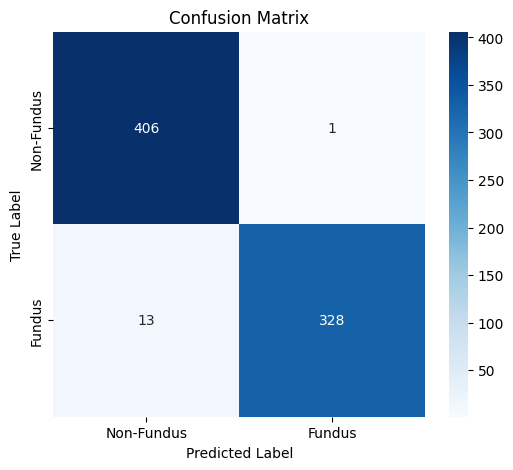

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fundus", "Fundus"], yticklabels=["Non-Fundus", "Fundus"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = "D:/saved_model_fundus.h5"

start_time = time.time()
model = load_model(model_path)
end_time = time.time()

print(f"Model loaded in {end_time - start_time:.2f} seconds")


Model loaded in 0.87 seconds


In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model_path = "D:/saved_model_fundus.h5"
model = tf.keras.models.load_model(model_path)



In [2]:
# Function to preprocess the image
def preprocess_single_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (same as training)
    return img_array


In [ ]:
img_path = r"D:\Datasets_Final\test\Fundus\N3.jpg"
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  

prediction = model.predict(img_array)

# Check output
print("Prediction:", prediction)

# Interpret the prediction based on your labeling (e.g., 0 = fundus, 1 = non-fundus)
if prediction[0] > 0.5:
    print("Model predicts: Non-Fundus")
else:
    print("Model predicts: Fundus")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: [[1.233044e-19]]
Model predicts: Fundus


In [ ]:
test_image_path = "C:\\Users\\User\\Downloads\\download.jpeg"
input_image = preprocess_single_image(test_image_path)
prediction = model.predict(input_image)

# Interpret Prediction
class_labels = ["Non-Fundus", "Fundus"]
predicted_class = class_labels[int(prediction[0] > 0.5)]
print(f"Predicted Class: {predicted_class} (Confidence: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Class: Non-Fundus (Confidence: 0.0000)


C:\Users\User\AppData\Local\Temp\ipykernel_19436\4066659428.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0.5)]
